In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import config as cfg

In [2]:
# Download stock prices
stock_data = yf.download(cfg.tickers, start=cfg.start_date, end=cfg.end_date)

df = pd.DataFrame(stock_data) # Transform stock prices to a dataframe
df = df.sort_values("Date") # stock_data is not ordered by default
df = df[["Close"]]
df.columns = df.columns.droplevel(0) # Convert to single level columns
print(df.head(10))

[*********************100%***********************]  212 of 212 completed

14 Failed downloads:
- TIS.MI: No data found, symbol may be delisted
- HOLN.PA: No data found, symbol may be delisted
- URW.AS: No data found, symbol may be delisted
- ATA.PA: No data found, symbol may be delisted
- GOE.PA: No data found, symbol may be delisted
- AKA.PA: No data found, symbol may be delisted
- ATI.PA: No data found, symbol may be delisted
- HEXA.PA: No data found, symbol may be delisted
- STM.PA: No data found, symbol may be delisted
- PHA.PA: No data found, symbol may be delisted
- CNP.PA: No data found, symbol may be delisted
- EUCAR.PA: No data found, symbol may be delisted
- 2CRSI.PA: No data found, symbol may be delisted
- ABIO.PA: No data found, symbol may be delisted
                     2CRSI.PA  A2A.MI  AB.PA  ABCA.PA  ABIO.PA  ABNX.PA  \
Date                                                                      
2000-07-31 00:00:00       NaN     NaN    NaN      NaN      NaN      NaN   
2

In [3]:
# watch_days_range = [2]
# hold_days_range = [5]
# num_stocks_to_buy_range = [1]
# loss_limit_range = [0.999]

watch_days_range = [1,2,3,4,5]
hold_days_range = [1,2,3,4,5,6,7,8]
num_stocks_to_buy_range = [1,2,3]
loss_limit_range = [0.999,0.99]

num_combinations = len(watch_days_range) * len(hold_days_range) * len(num_stocks_to_buy_range) * len(loss_limit_range)
combinations_per_minute = 6

print(f"Number of combinations: {num_combinations}, Estimated time: {(num_combinations / combinations_per_minute):.2f} minutes")

Number of combinations: 1, Estimated time: 0.17 minutes


In [4]:
results = []
combination_index = 0
total_profits = []

for watch_days in watch_days_range:  # watch_days represents the number of days for price increase calculation
    for hold_days in hold_days_range:  # hold_days represents the number of additional days before selling. Repeat for each period of watch_days plus hold_days
        num_iterations = int(len(df) / (watch_days + hold_days)) - 1

        for num_stocks_to_buy in num_stocks_to_buy_range:  # num_stocks_to_buy represents the number of stocks to buy
            for loss_limit in loss_limit_range:  # loss_limit represents the percentage decrease threshold for selling
                total_profit = 1

                for i in range(num_iterations):
                    start_watch_day_number = i * (watch_days + hold_days)
                    buy_day_number = start_watch_day_number + watch_days
                    sell_day_number = buy_day_number + hold_days

                    price_increase = df[start_watch_day_number:buy_day_number].pct_change(watch_days - 1).tail(1) # Calculate the price increase in the last watch_days days for each stock

                    if len(price_increase.columns) >= num_stocks_to_buy:
                        top_stocks = price_increase.squeeze().nlargest(num_stocks_to_buy).index # Select the num_stocks_to_buy stocks with the highest price increase
                        top_stocks = top_stocks.dropna()

                        buy_prices = df.loc[df.index[buy_day_number], top_stocks] # Calculate the buying prices at the start of the hold period
                        buy_prices = buy_prices.sort_index(axis=0)

                        hold_prices = df.loc[df.index[sell_day_number], top_stocks] # Calculate the selling prices after watch_days + hold_days days
                        hold_prices = hold_prices.sort_index(axis=0)

                        limit_prices = loss_limit * buy_prices

                        min_prices = df.iloc[buy_day_number+1:sell_day_number].min() # Calculate the minimum price in the holding period
                        min_prices = min_prices.loc[min_prices.index.intersection(top_stocks)]
                        min_prices = min_prices.sort_index(axis=0)
                        
                        condition = min_prices < limit_prices

                        sell_prices = hold_prices.copy()
                        sell_prices[condition] = limit_prices[condition]

                        profits = (sell_prices * (1 - cfg.fee)) / (buy_prices * (1 + cfg.fee)) # Calculate the profit for each stock
                        profits = profits.dropna()

                        profit = profits.mean(skipna=True) # Calculate the average of profits of the selected stocks
                        
                        total_profit *= profit if np.isfinite(profit) else 1

                        total_profits.append(total_profit)

                results.append({'watch_days': watch_days, 'num_stocks_to_buy': num_stocks_to_buy, 'hold_days': hold_days,
                                'loss_limit': loss_limit, 'total_profit': total_profit})
                
                print(f"Combination: {combination_index + 1} / {num_combinations}")
                combination_index += 1

results_df = pd.DataFrame(results)

Combination: 1 / 1


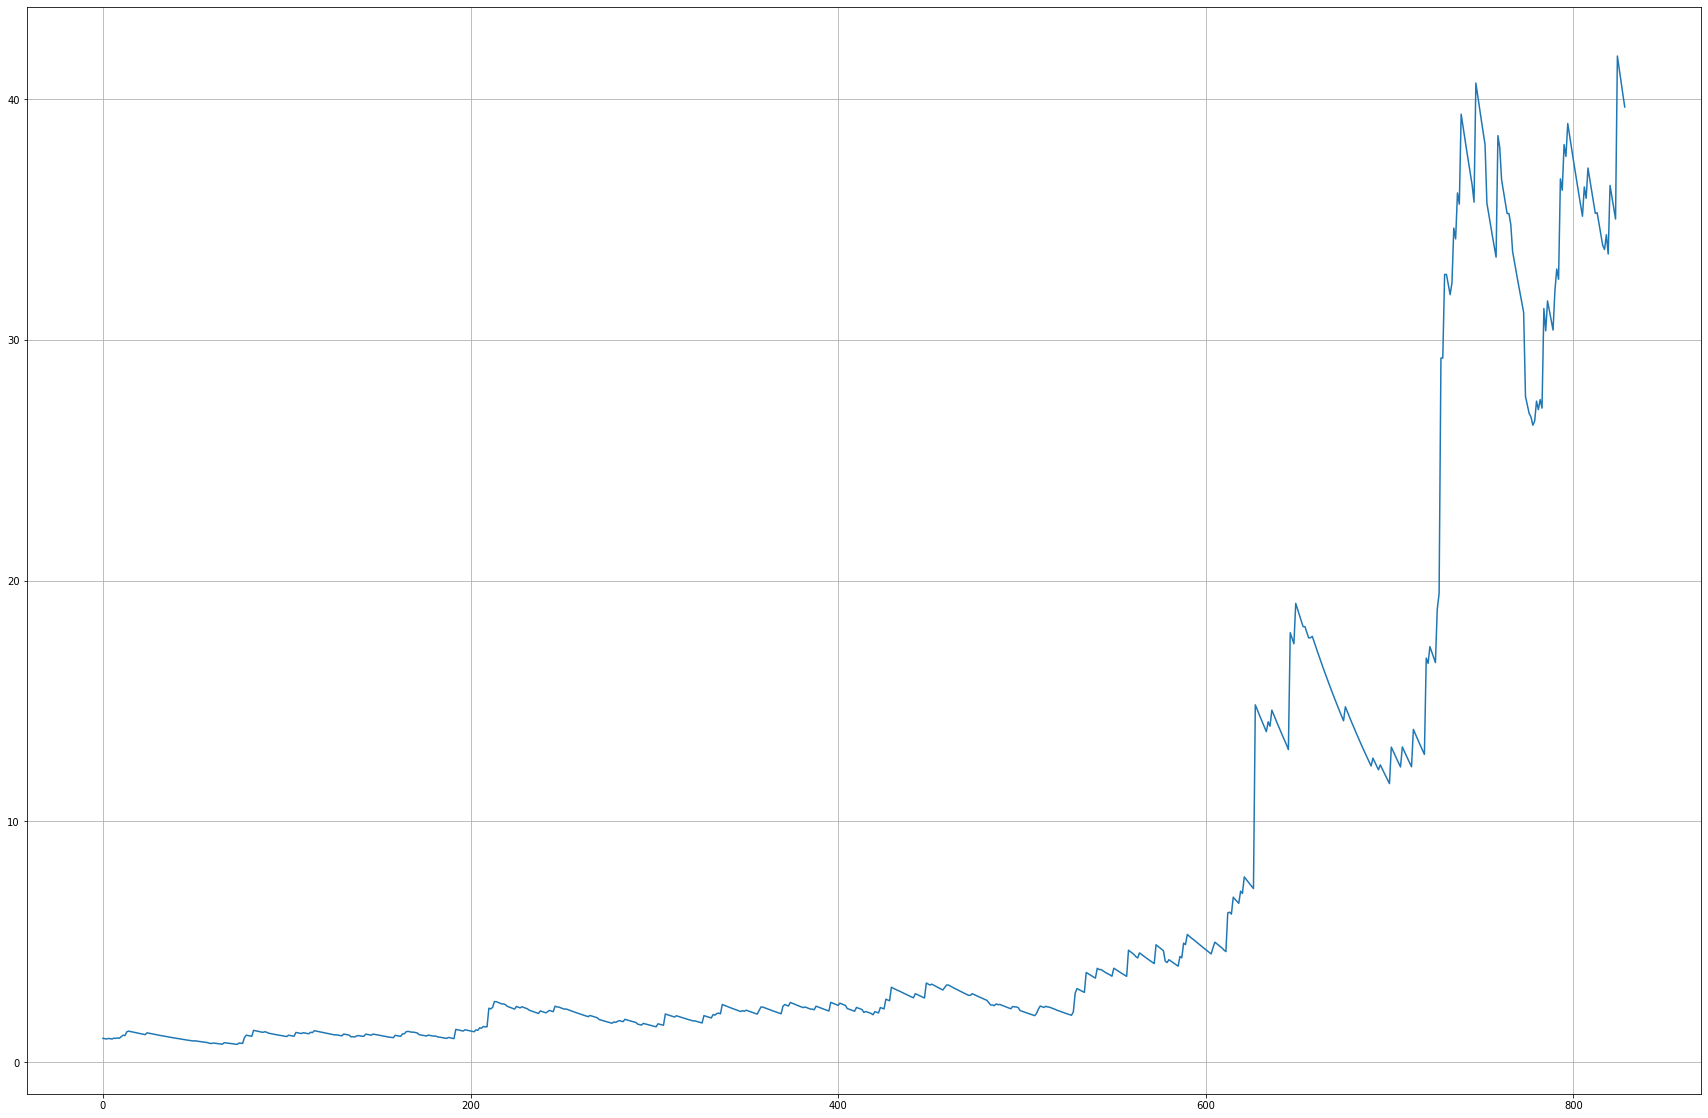

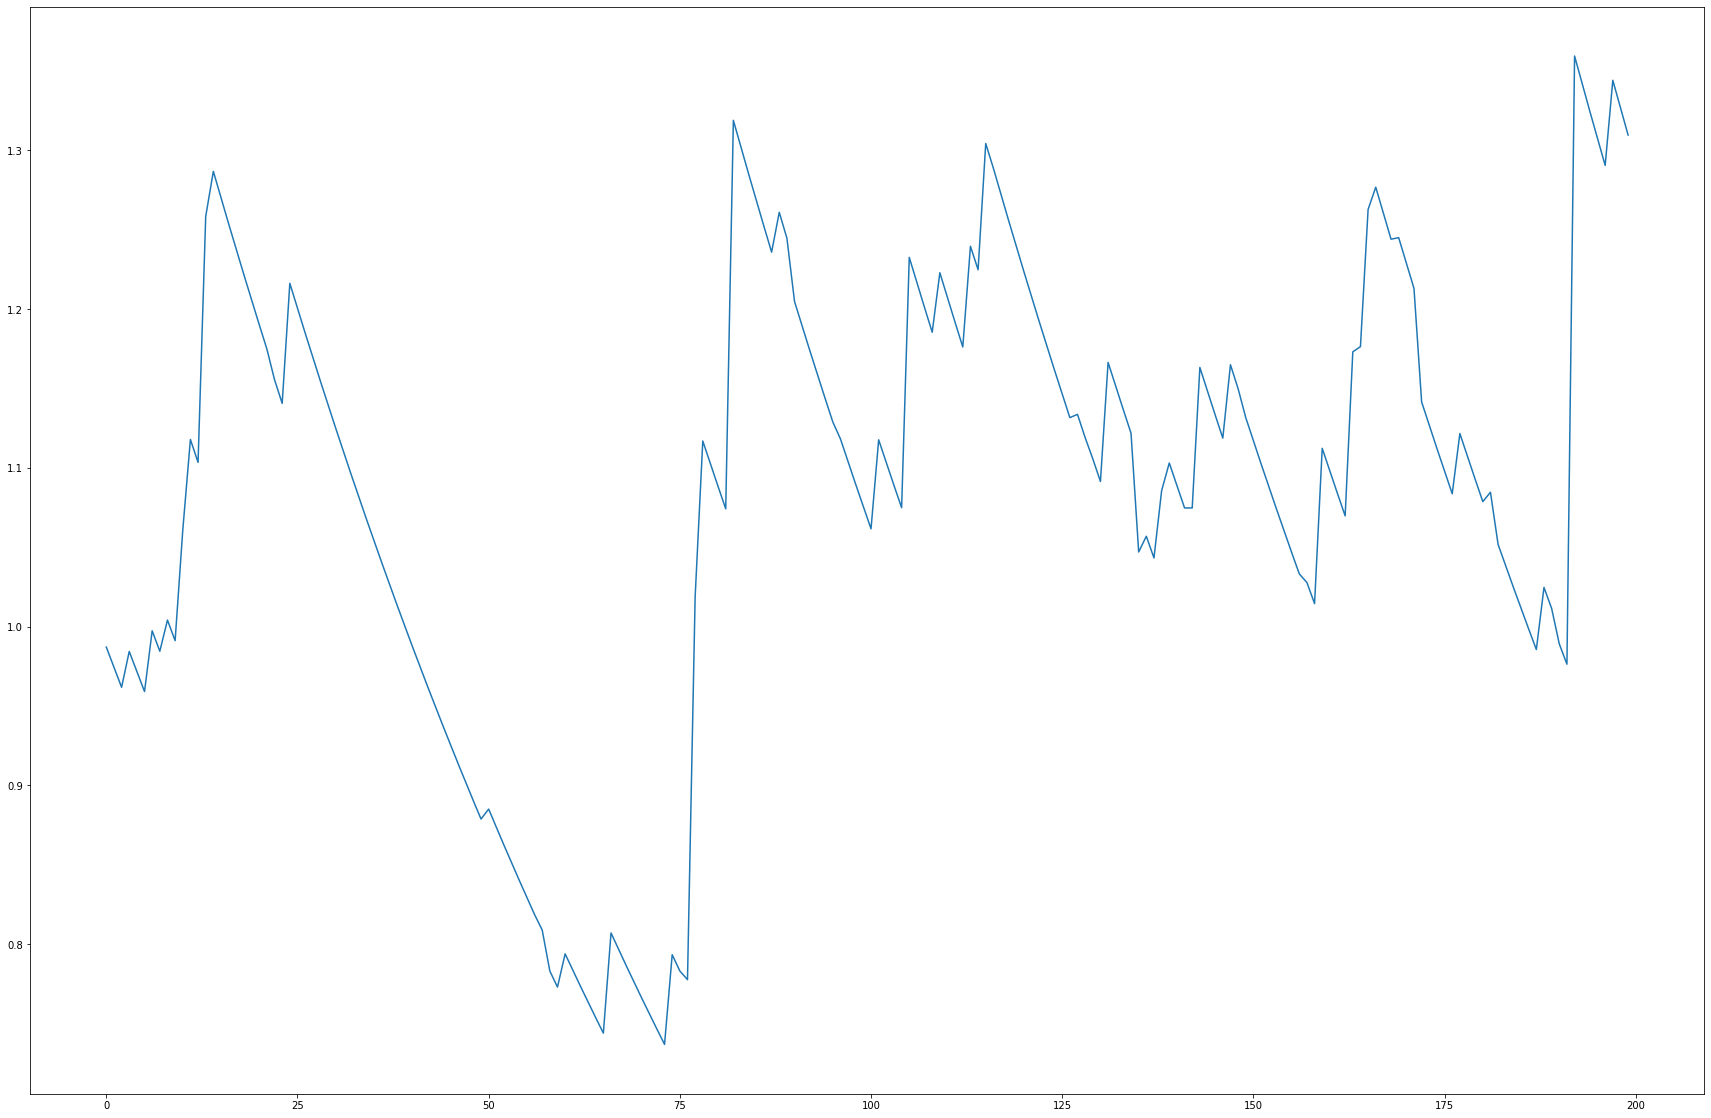

In [5]:
mpl.rcParams['figure.figsize'] = [30, 20]

plt.grid()
plt.plot(total_profits)
plt.show()
plt.plot(total_profits[:200])
plt.show()

In [6]:
print(results_df)

   watch_days  num_stocks_to_buy  hold_days  loss_limit  total_profit
0           2                  1          5       0.999     39.663862


In [7]:
results_df.sort_values("total_profit", ascending=False, inplace=True)

from datetime import datetime

def get_number_of_years(start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    delta = end - start
    return delta.days / 365.25

years = get_number_of_years(cfg.start_date, cfg.end_date)
results_df['yearly_profit'] = pow(results_df['total_profit'], 1 / years)

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
print(results_df.to_markdown())
# top_profit = results_df['total_profit'].max()
# top_yearly_profit = pow(top_profit, 1 / years)

# print(f"years: {years:.2f}, top_profit: x{top_profit:.2f}, top_yearly_profit: x{top_yearly_profit:.2f}")

|    |   watch_days |   num_stocks_to_buy |   hold_days |   loss_limit |   total_profit |   yearly_profit |
|---:|-------------:|--------------------:|------------:|-------------:|---------------:|----------------:|
|  0 |            2 |                   1 |           5 |        0.999 |        39.6639 |         1.17845 |
